In [1]:
import sys
print(sys.executable)
print(sys.version)

g:\Codes\Wave_energy_potential\env\python.exe
3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:39:58) [MSC v.1943 64 bit (AMD64)]


In [2]:
import cdsapi
import os

c = cdsapi.Client()
print(c)

os.makedirs("era5_wave_bn", exist_ok=True)

for m in range(1, 13):
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "significant_height_of_combined_wind_waves_and_swell",
                "mean_wave_period",
                "mean_wave_direction",
            ],
            "year": "2023",
            "month": f"{m:02d}",
            "day": [f"{d:02d}" for d in range(1, 32)],
            "time": [f"{h:02d}:00" for h in range(24)],
            "format": "netcdf",
            "area": [23, 88, 20, 93],
        },
        f"era5_wave_bn/era5_wave_2023{m:02d}.nc"
    )

2025-09-01 00:26:38,826 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-09-01 00:26:39,830 INFO Request ID is 64c73c6c-5858-4346-a4b6-a8197a077607
2025-09-01 00:26:40,139 INFO status has been updated to accepted
2025-09-01 00:26:49,705 INFO status has been updated to running
2025-09-01 00:27:57,950 INFO status has been updated to successful
2025-09-01 00:28:04,617 INFO Request ID is 5e2c0c68-be30-4d35-8dfe-368fb9e75cfa       
2025-09-01 00:28:04,930 INFO status has been updated to accepted
2025-09-01 00:28:10,673 INFO status has been updated to running
2025-09-01 00:29:22,614 INFO status has been updated to successful
2025-09-01 00:29:27,601 INFO Request ID is a6680e65-4ac1-4422-89b6-2b02b73eff42       
2025-09-01 00:29:27,912 INFO status has been updated to accepted
2025-09-01 00:29:37,303 INFO status has been updated to running
2025-09-01 00:31:24,636 INFO status has been updated to successful
2025-09-01 00:31:29,087 INFO Request ID is 5da439e9-50e4-4c01-a1bd-86fd4b3f3ea5       
2025-09-01 00:31:29,403 INFO status has been updated to accepted
2025-0

In [3]:
import xarray as xr

# Open dataset
ds1 = xr.open_dataset("era5_wave_bn/era5_wave_202301.nc")

print(ds1)


<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 744, latitude: 10, longitude: 12)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-01-01 ... 2023-01-31T23:...
  * latitude    (latitude) float64 80B 23.5 23.0 22.5 22.0 ... 20.0 19.5 19.0
  * longitude   (longitude) float64 96B 88.0 88.5 89.0 89.5 ... 92.5 93.0 93.5
    expver      (valid_time) <U4 12kB ...
Data variables:
    swh         (valid_time, latitude, longitude) float32 357kB ...
    mwp         (valid_time, latitude, longitude) float32 357kB ...
    mwd         (valid_time, latitude, longitude) float32 357kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-30T22:03 GRIB to CDM+CF via cfgrib-0.9.1...


Variables: ['swh', 'mwp', 'mwd']
Dimensions: FrozenMappingWarningOnValuesAccess({'valid_time': 8760, 'latitude': 7, 'longitude': 11})
Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
Using time coordinate: valid_time
First 5 timestamps: ['2023-01-01T00:00:00.000000000' '2023-01-01T01:00:00.000000000'
 '2023-01-01T02:00:00.000000000' '2023-01-01T03:00:00.000000000'
 '2023-01-01T04:00:00.000000000']
Last 5 timestamps: ['2023-12-31T19:00:00.000000000' '2023-12-31T20:00:00.000000000'
 '2023-12-31T21:00:00.000000000' '2023-12-31T22:00:00.000000000'
 '2023-12-31T23:00:00.000000000']
Wave height range (m): 0.07 to 8.77
Area-averaged SWH time series shape: (8760,)


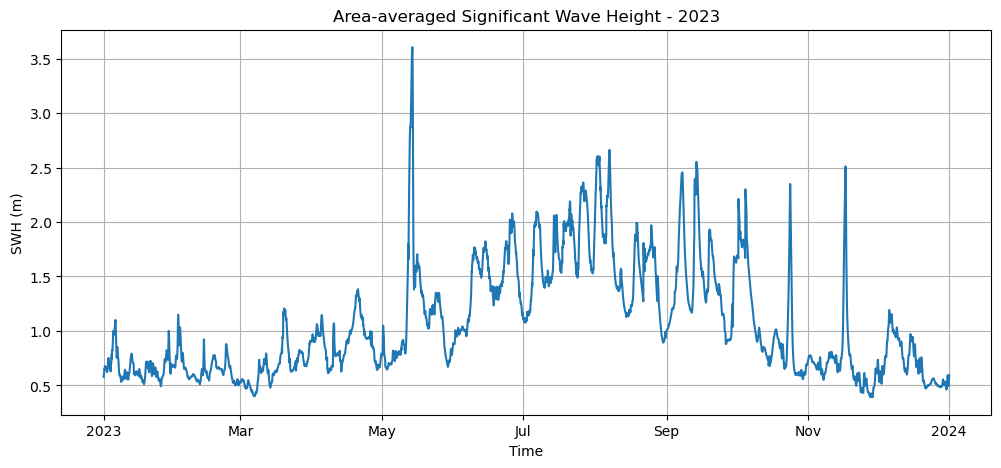

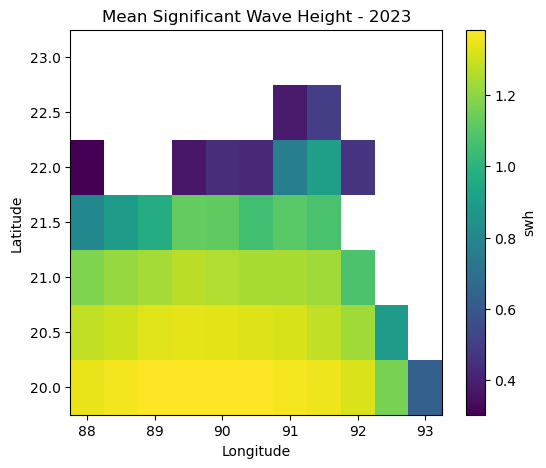

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import os

# Load all 2023 monthly files
files = sorted([f"era5_wave_bn/era5_wave_2023{m:02d}.nc" for m in range(1, 13) if os.path.exists(f"era5_wave_bn/era5_wave_2023{m:02d}.nc")])

# Open safely with concat along time
ds = xr.open_mfdataset(
    files,
    combine="nested",       # stack datasets
    concat_dim="valid_time",# concatenate along time dimension
    join="override"         # ignore small coord mismatches
)

# Inspect dataset
print("Variables:", list(ds.data_vars))
print("Dimensions:", ds.dims)
print("Coordinates:", list(ds.coords))

# Identify time coordinate
time_coord = "time" if "time" in ds.coords else "valid_time"
print(f"Using time coordinate: {time_coord}")

# Check timestamps
print("First 5 timestamps:", ds[time_coord].values[:5])
print("Last 5 timestamps:", ds[time_coord].values[-5:])

# Wave height range
swh_min = float(ds['swh'].min().values)
swh_max = float(ds['swh'].max().values)
print(f"Wave height range (m): {swh_min:.2f} to {swh_max:.2f}")

# Compute area-averaged time series
area_avg_swh = ds['swh'].mean(dim=["latitude", "longitude"])
print(f"Area-averaged SWH time series shape: {area_avg_swh.shape}")

# Plot area-averaged SWH over time (full year)
plt.figure(figsize=(12,5))
area_avg_swh.plot()
plt.title("Area-averaged Significant Wave Height - 2023")
plt.ylabel("SWH (m)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

# Compute spatial mean for the whole year and plot map
mean_swh = ds['swh'].mean(dim=time_coord)

plt.figure(figsize=(6,5))
mean_swh.plot(cmap="viridis")
plt.title("Mean Significant Wave Height - 2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [4]:
print("Latitude range:", float(ds.latitude.min()), "to", float(ds.latitude.max()))
print("Longitude range:", float(ds.longitude.min()), "to", float(ds.longitude.max()))


Latitude range: 20.0 to 23.0
Longitude range: 88.0 to 93.0


<xarray.DataArray 'mwp' (valid_time: 8760, latitude: 7, longitude: 11)> Size: 3MB
dask.array<concatenate, shape=(8760, 7, 11), dtype=float32, chunksize=(744, 7, 11), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23...
  * latitude    (latitude) float64 56B 23.0 22.5 22.0 21.5 21.0 20.5 20.0
  * longitude   (longitude) float64 88B 88.0 88.5 89.0 89.5 ... 92.0 92.5 93.0
    expver      (valid_time) <U4 140kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/32)
    GRIB_paramId:                             140232
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      77
    GRIB_typeOfLevel:                         meanSea
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:          

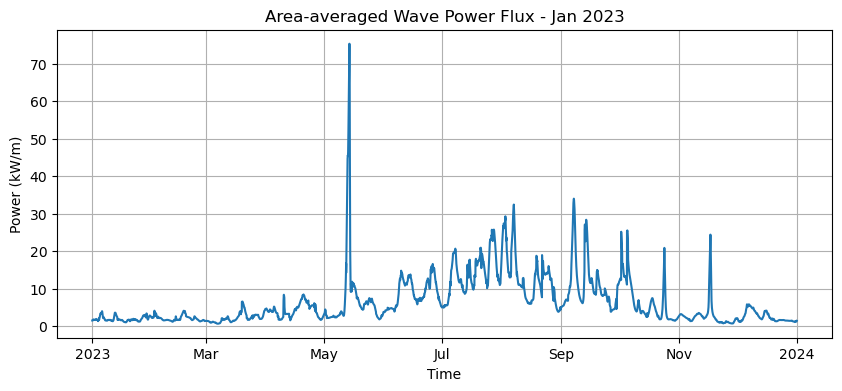

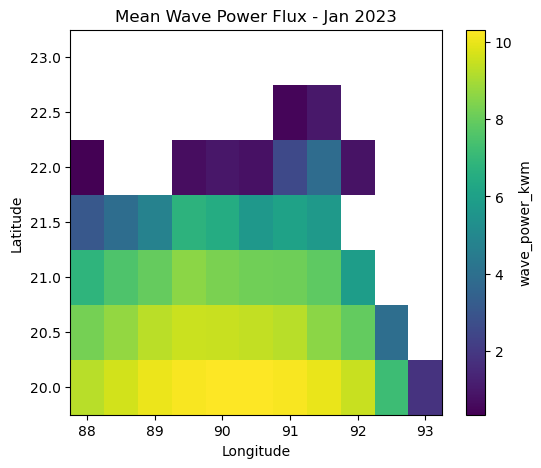

In [5]:
# Constants
rho = 1025  # kg/m^3
g = 9.81    # m/s^2

# ERA5 provides:
# swh = significant wave height (m)
# mwp = mean wave period (s)
Hs = ds['swh']
Te = ds['mwp']
print(Te)

# Deep-water wave power formula (kW/m)
# P = (ρ * g^2 / 64π) * Hs^2 * Te / 1000  (convert W to kW)
P = (rho * g**2 / (64 * 3.1416)) * Hs**2 * Te / 1000

# Add to dataset
ds['wave_power_kwm'] = P

# Compute area-averaged wave power time series
P_area_avg = ds['wave_power_kwm'].mean(dim=['latitude', 'longitude'])

print(P_area_avg)


# Time series of area-averaged wave power

plt.figure(figsize=(10,4))
P_area_avg.plot()
plt.title("Area-averaged Wave Power Flux - Jan 2023")
plt.ylabel("Power (kW/m)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

# Spatial mean map for the month

if ds[time_coord].size > 1:
    P_mean_map = ds['wave_power_kwm'].mean(dim=time_coord)
else:
    P_mean_map = ds['wave_power_kwm']

plt.figure(figsize=(6,5))
P_mean_map.plot(cmap='viridis')
plt.title("Mean Wave Power Flux - Jan 2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
